# Heart Disease Detection using Artificial Neural Network (ANN)

In this notebook, we build an Artificial Neural Network (ANN) model using **TensorFlow and Keras** to predict heart disease based on clinical attributes.

We'll follow these steps:
1. Import libraries  
2. Load and explore dataset  
3. Preprocess data  
4. Build and train ANN model  
5. Evaluate performance  
6. Save model and scaler for deployment


### Step 1 - Import required libraries

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Set random seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Step 2 - Load dataset

In [49]:
# Load the Heart Disease dataset (CSV should be in ./data folder)
df = pd.read_csv("../data/heart.csv")

# Display first 5 rows
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset contains various medical attributes such as age, sex, cholesterol, etc., and a target column:
- `target = 1`: presence of heart disease  
- `target = 0`: no heart disease


### Step 3 - Separate features and labels

In [50]:
# Separate input features (X) and target labels (y)
X = df.drop(columns=["target"])
y = df["target"]

print("Shape of features (X):", X.shape)
print("Shape of labels (y):", y.shape)

Shape of features (X): (303, 13)
Shape of labels (y): (303,)


### Step 4 - Preprocessing the data

In [51]:
# One-hot encode categorical columns (if any)
X = pd.get_dummies(X, drop_first=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Scale numerical features for faster convergence
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessing complete.")

Data preprocessing complete.


We used:
- **One-hot encoding** for categorical variables  
- **StandardScaler** for normalization (mean=0, std=1)  
- **Train-test split** (80% training, 20% testing)

### Step 5 - Build the ANN model

In [52]:
# Build a simple feedforward ANN model
model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        # Wider first layer with stronger L2 regularization
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.Dropout(0.3),
        
        # Second layer (same size)
        layers.Dense(64, activation='relu'), # Removed L2 here to focus regularization on the first layer
        layers.Dropout(0.3),

        # New, smaller third layer for feature consolidation
        layers.Dense(32, activation='relu'), 

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Summary of the network
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

**Model architecture:**
- Input layer: number of features = `X_train.shape[1]`
- Hidden layers: 64 and 32 neurons, ReLU activation
- Dropout (30%) to prevent overfitting
- Output layer: 1 neuron, Sigmoid activation for binary classification

### Step 6 - Train the model

In [ ]:
# Early stopping to avoid overfitting
es = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=es, # Added Early Stopping
    verbose=2
)

Epoch 1/200
7/7 - 1s - 142ms/step - accuracy: 0.5463 - auc: 0.5882 - loss: 0.7073 - val_accuracy: 0.7568 - val_auc: 0.9279 - val_loss: 0.6130 - learning_rate: 1.0000e-03
Epoch 2/200
7/7 - 0s - 4ms/step - accuracy: 0.6878 - auc: 0.7565 - loss: 0.6500 - val_accuracy: 0.8919 - val_auc: 0.9776 - val_loss: 0.5364 - learning_rate: 1.0000e-03
Epoch 3/200
7/7 - 0s - 4ms/step - accuracy: 0.8049 - auc: 0.8740 - loss: 0.5924 - val_accuracy: 0.9189 - val_auc: 0.9776 - val_loss: 0.4550 - learning_rate: 1.0000e-03
Epoch 4/200
7/7 - 0s - 3ms/step - accuracy: 0.7756 - auc: 0.8782 - loss: 0.5550 - val_accuracy: 0.8649 - val_auc: 0.9744 - val_loss: 0.3844 - learning_rate: 1.0000e-03
Epoch 5/200
7/7 - 0s - 4ms/step - accuracy: 0.8244 - auc: 0.8815 - loss: 0.5147 - val_accuracy: 0.8649 - val_auc: 0.9728 - val_loss: 0.3291 - learning_rate: 1.0000e-03
Epoch 6/200
7/7 - 0s - 3ms/step - accuracy: 0.8146 - auc: 0.8796 - loss: 0.4776 - val_accuracy: 0.8919 - val_auc: 0.9679 - val_loss: 0.2988 - learning_rate: 1

We monitor the **AUC (Area Under ROC Curve)** on the validation set and stop training when improvement stalls.

### Step 7 - Visualize training performance

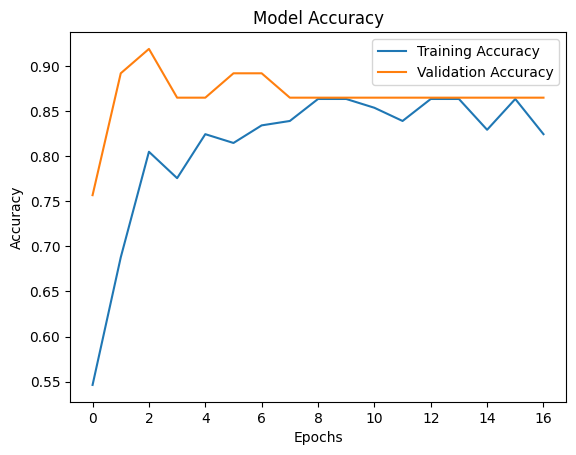

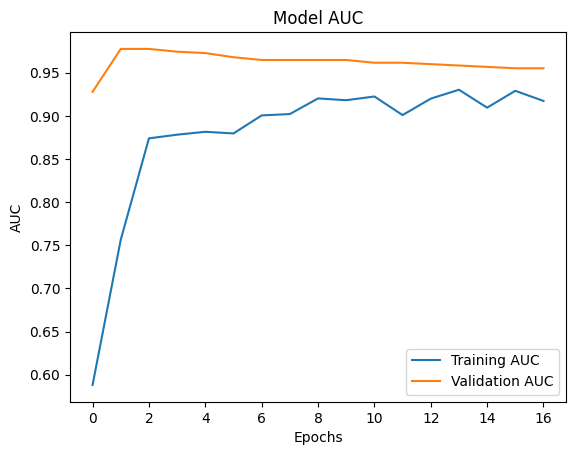

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Model AUC')
plt.show()

### Step 8 - Evaluate model on test data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61

✅ Accuracy:  0.803
🎯 Precision: 0.769
🔁 Recall:    0.909
💡 F1-score:  0.833
🏆 AUC:       0.903


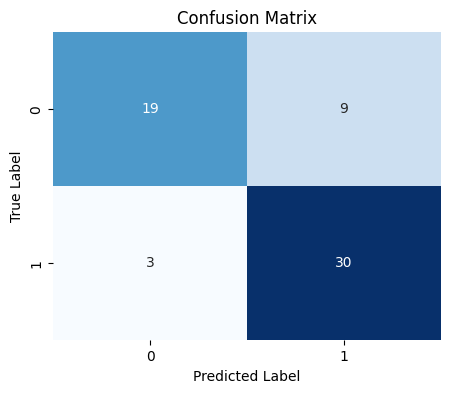

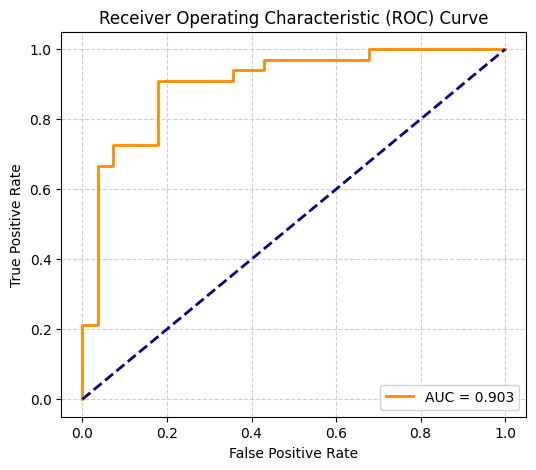

/var/folders/dy/n39312m176q_0131_6rzrpxm0000gn/T/ipykernel_41379/48429459.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='crest')


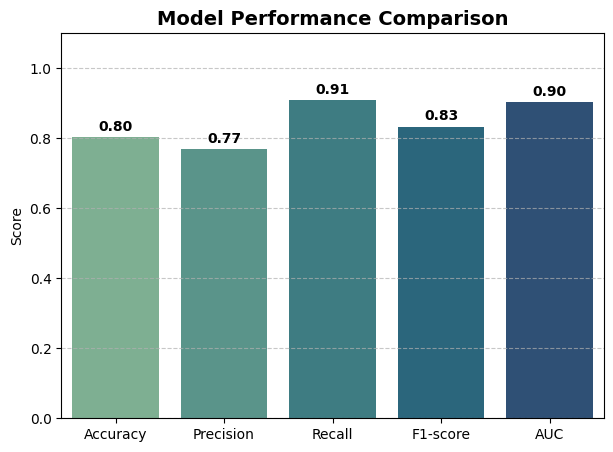

In [55]:
# 🧠 Model Evaluation Section

from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    f1_score, precision_score, recall_score, roc_curve
)
import seaborn as sns

# Predict probabilities and labels
probs = model.predict(X_test).ravel()
preds = (probs >= 0.5).astype(int)

# --- Metrics ---
accuracy = np.mean(preds == y_test)
f1 = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
auc = roc_auc_score(y_test, probs)

# Print detailed classification report
print("📋 Classification Report:\n", classification_report(y_test, preds))
print(f"✅ Accuracy:  {accuracy:.3f}")
print(f"🎯 Precision: {precision:.3f}")
print(f"🔁 Recall:    {recall:.3f}")
print(f"💡 F1-score:  {f1:.3f}")
print(f"🏆 AUC:       {auc:.3f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Metrics Bar Plot ---

# Collect metrics into a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "AUC": auc
}

# Convert to DataFrame for easy plotting
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

plt.figure(figsize=(7,5))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='crest')

# Add value labels on bars
for i, val in enumerate(metrics_df['Value']):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 1.1)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The model’s effectiveness can be measured by:
- **Accuracy**
- **Precision & Recall**
- **AUC (Area Under the Curve)**
- **Confusion Matrix**

### Comparison with other algorithms like SVM, Logistic and Random Forest

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
}

for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    print(f"{name} Accuracy:", accuracy_score(y_test, preds))

print("Our Model Accuracy:", accuracy)

Logistic Regression Accuracy: 0.8032786885245902
Random Forest Accuracy: 0.819672131147541
SVM Accuracy: 0.819672131147541
Our Model Accuracy: 0.8032786885245902


### Step 9 - Save the model and scaler

In [44]:
import joblib

# Save trained model and scaler for later use in Flask backend
model.save("../models/heart_model.keras")
joblib.dump(scaler, "../scaler/heart_scaler.pkl")

print("✅ Model and Scaler saved successfully!")

✅ Model and Scaler saved successfully!


## Summary
### Key Takeaways:
- Built and trained a fully connected ANN for heart disease prediction.
- Used dropout and L2 regularization to reduce overfitting.
- Achieved a good AUC score and accuracy on unseen test data.
- Saved both model and scaler for integration with a Flask web app.

Next Step → Integrate this model into a Flask backend for real-time predictions.